In [42]:
from FC.FC_save_load_global_hook_dict import load_csv_to_dict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
import os

***
# **Wiederholungsgenauigkeit**

**Dicts laden**

In [43]:
dir_path = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/6_Wiederholungsgenauigkeit/HakenmodellD/csv'

In [44]:
dicts_list = []

for testrun_folder in sorted(os.listdir(dir_path)):
    testrun_folder_path = os.path.join(dir_path, testrun_folder)

    if os.path.isdir(testrun_folder_path) and testrun_folder.isdigit():
        data = os.listdir(testrun_folder_path)
        csv_data = [f for f in data if f.endswith('.csv')]

        if len(csv_data) == 1:
            csv_path = os.path.join(testrun_folder_path, csv_data[0])
            dicts_list.append(load_csv_to_dict(csv_path))
        else:
            print(f"No CSV file in: {testrun_folder_path}")

print(f"{len(dicts_list)} Dictionaries found...")

No CSV file in: /home/mo/Thesis/Evaluation/1_Scan-Prozess/6_Wiederholungsgenauigkeit/HakenmodellD/csv/50
49 Dictionaries found...


**Mittelwert der Koordinaten pro Haken berechnen**

In [45]:
def calculate_mean(dicts_list = None):
    """
    Berechnet für alle Koordnaten (Spitze und Senke) den Mittelwert X_mean, Y_mean, Z_mean für jeden Haken"
    """
    mean_xyz_tip_in_workframe = []
    mean_xyz_lowpoint_in_workframe = []

    for hook_idx in range(len(dicts_list[0])):
        # hole Haken x aus allen dicts und berechne Summe
        sum_xyz_tip = np.zeros(3)
        sum_xyz_lowpoint = np.zeros(3)
        
        dict_key = str(hook_idx + 1)
        for dict in (dicts_list):
            xyz_tip_in_workframe = dict[dict_key]['xyz_tip_in_workframe']
            xyz_lowpoint_in_workframe = dict[dict_key]['xyz_lowpoint_in_workframe']
            sum_xyz_tip += xyz_tip_in_workframe
            sum_xyz_lowpoint += xyz_lowpoint_in_workframe
        
        # Berechne Mittelwert für Haken x und hänge an Ergebnis-Liste dran
        tip_mean = sum_xyz_tip / len(dicts_list)
        lowpoint_mean = sum_xyz_lowpoint / len(dicts_list)
        mean_xyz_tip_in_workframe.append(tip_mean)
        mean_xyz_lowpoint_in_workframe.append(lowpoint_mean)

    return mean_xyz_tip_in_workframe, mean_xyz_lowpoint_in_workframe

**Werte als Scatter plotten**

In [ ]:
def plot_values(dicts_list=None, tip_mean_list=None, lowpoint_mean_list=None):
    """
    Plottet die x, y, z-Werte für jeden Haken-Tip und -Lowpoint in einem 2x3 Plot.
    Links: Tip-Koordinaten (x, y, z)
    Rechts: Lowpoint-Koordinaten (x, y, z)
    """
    num_hooks = len(dicts_list[0])
    num_samples = len(dicts_list)

    # Datenstruktur initialisieren
    tips = np.zeros((num_hooks, num_samples, 3))       # shape: (hooks, samples, xyz)
    lowpoints = np.zeros((num_hooks, num_samples, 3))  # shape: (hooks, samples, xyz)

    for hook_idx in range(num_hooks):
        dict_key = str(hook_idx + 1)
        for sample_idx, d in enumerate(dicts_list):
            tips[hook_idx, sample_idx] = d[dict_key]['xyz_tip_in_workframe']
            lowpoints[hook_idx, sample_idx] = d[dict_key]['xyz_lowpoint_in_workframe']

    fig, axs = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
    fig.suptitle('Wiederholungsgenauigkeit bei gleichem Hakenmodell bzw. Setup')
    coord_labels = ['x', 'y', 'z']

    for i in range(3):  # Für x, y, z
        # Tip-Daten plotten (linke Spalte)
        # axs[i, 0].plot(range(1, num_hooks + 1), tips[:, :, i].mean(axis=1), label='Mean', marker='o')
        axs[i, 0].scatter(np.repeat(np.arange(1, num_hooks + 1), num_samples), 
                         tips[:, :, i].flatten(), alpha=0.6, label='Koordinate')
        if tip_mean_list:
            axs[i, 0].plot(range(1, num_hooks + 1), [tip_mean_list[hook_idx][i] for hook_idx in range(num_hooks)], 
                           label='Mittelwert', linestyle='--', color='red')
        axs[i, 0].set_ylabel(f'Spitze {coord_labels[i]}')
        axs[i, 0].legend()
        axs[i, 0].grid()

        # Lowpoint-Daten plotten (rechte Spalte)
        # axs[i, 1].plot(range(1, num_hooks + 1), lowpoints[:, :, i].mean(axis=1), label='Mean', marker='o')
        axs[i, 1].scatter(np.repeat(np.arange(1, num_hooks + 1), num_samples), 
                         lowpoints[:, :, i].flatten(), alpha=0.6, label='Koordinate')
        if lowpoint_mean_list:
            axs[i, 1].plot(range(1, num_hooks + 1), [lowpoint_mean_list[hook_idx][i] for hook_idx in range(num_hooks)], 
                           label='Mittelwert', linestyle='--', color='red')
        axs[i, 1].set_ylabel(f'Senke {coord_labels[i]}')
        axs[i, 1].legend()
        axs[i, 1].grid()

    for ax in axs[2]:
        ax.set_xlabel('Hook Index')

    plt.tight_layout()
    plt.show()

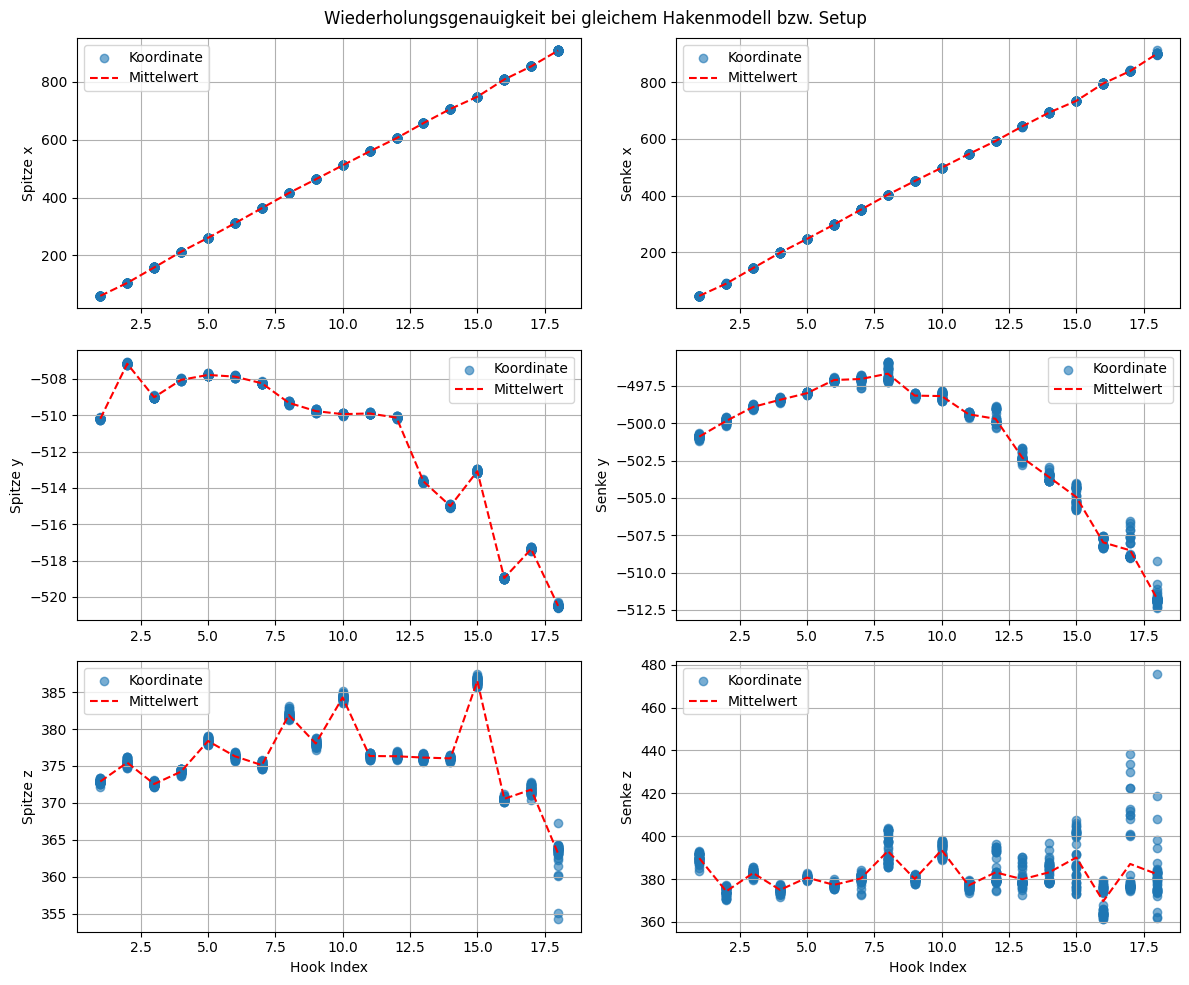

In [49]:
mean_xyz_tip_in_workframe, mean_xyz_lowpoint_in_workframe = calculate_mean(dicts_list)
plot_values(dicts_list = dicts_list, tip_mean_list = mean_xyz_tip_in_workframe, lowpoint_mean_list = mean_xyz_lowpoint_in_workframe)

### **Wahrscheinlichkeits-Verteilung**

In [33]:
def plot_z_distribution(dicts_list, hook_num=1):
    """
    Plottet die Verteilung der z-Koordinaten der Spitzen über alle Haken und Messungen hinweg.
    Zeigt Histogramm + angepasste Normalverteilung sowie μ und σ im Plot.
    """
    z_values = []

    num_scans = len(dicts_list)

    # gehe alle Dicts durch und nehme überall den gleichen Haken heraus
    for scan_idx in range(num_scans):
        for scan_dict in dicts_list:
            z = scan_dict[str(hook_num)]['xyz_tip_in_workframe'][2]
            z_values.append(z)

    z_values = np.array(z_values)

    # Fit Normalverteilung
    mu, std = norm.fit(z_values)

    # Histogramm
    plt.figure(figsize=(8, 5))
    bins = int(np.ceil(np.log2(len(z_values)) + 1))  # Sturges-Regel
    print(f"Using {bins} bins...")
    count, bins, ignored = plt.hist(z_values, bins=bins, density=True, alpha=0.6,
                                     color='gray', edgecolor='black', label='Messwerte')

    # PDF der Normalverteilung -> Wahrscheinlichkeitsdichte berechnen
    x = np.linspace(min(bins), max(bins), 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2, label='Normalverteilung')

    # Anzeige der Parameter
    plt.title("Verteilung der z-Koordinaten (Tiefe)")
    plt.xlabel("z-Wert")
    plt.ylabel("Dichte")
    plt.legend()
    plt.text(0.95, 0.95, f'μ = {mu:.2f}\nσ = {std:.2f}',
             ha='right', va='top', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.tight_layout()
    plt.show()

    return mu, std

In [34]:
def plot_xyz_distribution(dicts_list, hook_num=1, n_components=2):
    """
    Plottet die Verteilungen der x-, y- und z-Koordinaten eines bestimmten Hakens
    als Histogramme mit Normalverteilung und GMM.
    """
    x_values, y_values, z_values = [], [], []

    for scan_dict in dicts_list:
        coords = scan_dict[str(hook_num)]['xyz_tip_in_workframe']
        x_values.append(coords[0])
        y_values.append(coords[1])
        z_values.append(coords[2])

    axis_labels = ['x', 'y', 'z']
    all_coords = [x_values, y_values, z_values]
    mu_std_results = {}

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, (coord, label) in enumerate(zip(all_coords, axis_labels)):
        data = np.array(coord).reshape(-1, 1)
        mu, std = norm.fit(data)

        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(data)
        weights = gmm.weights_
        means = gmm.means_.flatten()
        covs = gmm.covariances_.flatten()
        stds = np.sqrt(covs)

        x_plot = np.linspace(data.min(), data.max(), 1000)
        norm_pdf = norm.pdf(x_plot, mu, std)

        axs[i].hist(data, bins='sturges', density=True, alpha=0.6,
                    color='gray', edgecolor='black', label='Messwerte')
        axs[i].plot(x_plot, norm_pdf, 'r', linewidth=2, label='Normalverteilung')

        gmm_total = np.zeros_like(x_plot)
        for j in range(n_components):
            comp_pdf = weights[j] * norm.pdf(x_plot, means[j], stds[j])
            gmm_total += comp_pdf
            axs[i].plot(x_plot, comp_pdf, '--', linewidth=1.2, label=f'GMM Komp. {j+1}')

        axs[i].plot(x_plot, gmm_total, 'b', linewidth=2, label='GMM Gesamt')
        axs[i].set_title(f"Verteilung der {label}-Koordinate (Haken {hook_num})")
        axs[i].set_xlabel(f"{label}-Wert")
        axs[i].set_ylabel("Dichte")
        axs[i].legend()
        axs[i].text(0.95, 0.95, f'μ = {mu:.2f}\nσ = {std:.2f}',
                    ha='right', va='top', transform=axs[i].transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

        mu_std_results[label] = (mu, std)

    plt.tight_layout()
    plt.show()

    return mu_std_results

In [35]:
'''
sums = {'x': 0, 'y': 0, 'z': 0}
counts = len(dicts_list[0])

for hook_num in range(1, counts + 1):
    print(f"\n=== Haken {hook_num} ===")
    mu_std = plot_xyz_distribution(dicts_list, hook_num=hook_num, n_components=2)
    
    for axis in ['x', 'y', 'z']:
        mu, std = mu_std[axis]
        print(f"{axis}-Achse → μ = {mu:.2f}, σ = {std:.2f}")
        sums[axis] += mu  # Nur Mittelwert aufsummieren, kannst auch std dazunehmen

# Durchschnittswerte
print("\n--- Durchschnittlicher Mittelwert über alle Haken ---")
for axis in ['x', 'y', 'z']:
    print(f"{axis}-Achse → Durchschnittlicher μ = {sums[axis] / counts:.2f}")'
'''

'\nsums = {\'x\': 0, \'y\': 0, \'z\': 0}\ncounts = len(dicts_list[0])\n\nfor hook_num in range(1, counts + 1):\n    print(f"\n=== Haken {hook_num} ===")\n    mu_std = plot_xyz_distribution(dicts_list, hook_num=hook_num, n_components=2)\n    \n    for axis in [\'x\', \'y\', \'z\']:\n        mu, std = mu_std[axis]\n        print(f"{axis}-Achse → μ = {mu:.2f}, σ = {std:.2f}")\n        sums[axis] += mu  # Nur Mittelwert aufsummieren, kannst auch std dazunehmen\n\n# Durchschnittswerte\nprint("\n--- Durchschnittlicher Mittelwert über alle Haken ---")\nfor axis in [\'x\', \'y\', \'z\']:\n    print(f"{axis}-Achse → Durchschnittlicher μ = {sums[axis] / counts:.2f}")\'\n'

**Berechnung der Treffer-Wahrscheinlichkeit - Spitze wird als unendlich kleiner Punkt angenommen**

In [36]:
def probability_within_slot_gmm(dicts_list, hook_num=1, slot_length=12, slot_width=5, slot_depth=10, n_components=2):
    coords = {'x': [], 'y': [], 'z': []}
    for d in dicts_list:
        pt = d[str(hook_num)]['xyz_tip_in_workframe']
        coords['x'].append(pt[0])
        coords['y'].append(pt[1])
        coords['z'].append(pt[2])

    slot_half = {
        'x': slot_width / 2,
        'y': slot_depth / 2,
        'z': slot_length / 2
    }

    total_prob = 1.0
    for axis in ['x', 'y', 'z']:
        data = np.array(coords[axis]).reshape(-1, 1)
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(data)

        weights = gmm.weights_
        means = gmm.means_.flatten()
        stds = np.sqrt(gmm.covariances_.flatten())
        center = np.mean(data)
        lower = center - slot_half[axis]
        upper = center + slot_half[axis]

        # Komponentensumme der Wahrscheinlichkeit
        prob_axis = 0
        for w, mu, sigma in zip(weights, means, stds):
            cdf_upper = norm.cdf((upper - mu) / sigma)
            cdf_lower = norm.cdf((lower - mu) / sigma)
            prob_axis += w * (cdf_upper - cdf_lower)

        print(f"{axis}-Achse: μ-Komponenten = {np.round(means, 2)}, σ-Komponenten = {np.round(stds, 2)}, Gewichte = {np.round(weights, 2)}")
        print(f"Zielbereich: [{lower:.2f}, {upper:.2f}] → Wahrscheinlichkeit = {prob_axis*100:.2f} %\n")
        total_prob *= prob_axis

    print(f"Gesamte Wahrscheinlichkeit für das Treffen der Hakenspitze (GMM): {total_prob*100:.2f} %\n")
    return total_prob

In [37]:
prob = probability_within_slot_gmm(dicts_list, hook_num=10, slot_length=12, slot_width=8, slot_depth=10, n_components=1)

x-Achse: μ-Komponenten = [511.53], σ-Komponenten = [0.12], Gewichte = [1.]
Zielbereich: [507.53, 515.53] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-509.95], σ-Komponenten = [0.03], Gewichte = [1.]
Zielbereich: [-514.95, -504.95] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [384.26], σ-Komponenten = [0.35], Gewichte = [1.]
Zielbereich: [378.26, 390.26] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit für das Treffen der Hakenspitze (GMM): 100.00 %



**Berechnung der Treffer-Wahrscheinlichkeit unter Berücksichtigung der Spitzendicke und der Lochgröße**

In [38]:
def probability_within_slot_gmm(dicts_list, hook_num=1,
                                 slot_length=12, slot_width=5, slot_depth=10,
                                 tip_width=7, tip_to_lp_dist=9, tip_length=10,
                                 n_components=2):
    coords = {'x': [], 'y': [], 'z': []}
    for d in dicts_list:
        pt = d[str(hook_num)]['xyz_tip_in_workframe']
        coords['x'].append(pt[0])
        coords['y'].append(pt[1])
        coords['z'].append(pt[2])

    # Sicherheitsabstand: Halbe Slotgröße MINUS halbe Spitzenabmessung
    slot_half = {
        'x': (slot_width / 2) - (tip_width / 2),
        'y': (slot_depth / 2) - (tip_to_lp_dist / 2),
        'z': (slot_length / 2) - (tip_length / 2)
    }

    for axis in ['x', 'y', 'z']:
        if slot_half[axis] <= 0:
            raise ValueError(f"Spitze ist größer als das Slot in {axis}-Richtung!")

    total_prob = 1.0
    for axis in ['x', 'y', 'z']:
        data = np.array(coords[axis]).reshape(-1, 1)
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(data)

        weights = gmm.weights_
        means = gmm.means_.flatten()
        stds = np.sqrt(gmm.covariances_.flatten())
        center = np.mean(data)
        lower = center - slot_half[axis]
        upper = center + slot_half[axis]

        prob_axis = 0
        for w, mu, sigma in zip(weights, means, stds):
            cdf_upper = norm.cdf((upper - mu) / sigma)
            cdf_lower = norm.cdf((lower - mu) / sigma)
            prob_axis += w * (cdf_upper - cdf_lower)

        print(f"{axis}-Achse: μ-Komponenten = {np.round(means, 2)}, σ-Komponenten = {np.round(stds, 2)}, Gewichte = {np.round(weights, 2)}")
        print(f"Zielbereich (angepasst): [{lower:.2f}, {upper:.2f}] → Wahrscheinlichkeit = {prob_axis*100:.2f} %\n")
        total_prob *= prob_axis

    print(f"\033[1mGesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): {total_prob*100:.2f} %\n\033[0m")
    return total_prob

In [39]:
def plot_xyz_distribution(dicts_list, hook_num=1, n_components=2,
                          slot_length=12, slot_width=5, slot_depth=10,
                          tip_width=2, tip_to_lp_dist=2, tip_length=1):
    """
    Plottet die Verteilungen der x-, y- und z-Koordinaten eines bestimmten Hakens
    inkl. Histogramm, Normalverteilung, GMM-Komponenten und Trefferbereich.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import norm
    from sklearn.mixture import GaussianMixture

    x_values, y_values, z_values = [], [], []

    for scan_dict in dicts_list:
        coords = scan_dict[str(hook_num)]['xyz_tip_in_workframe']
        x_values.append(coords[0])
        y_values.append(coords[1])
        z_values.append(coords[2])

    axis_labels = ['x', 'y', 'z']
    all_coords = [x_values, y_values, z_values]
    slot_dims = {'x': slot_width, 'y': slot_depth, 'z': slot_length}
    tip_dims = {'x': tip_width, 'y': tip_to_lp_dist, 'z': tip_length}
    mu_std_results = {}

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, (coord, label) in enumerate(zip(all_coords, axis_labels)):
        data = np.array(coord).reshape(-1, 1)
        mu, std = norm.fit(data)

        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(data)
        weights = gmm.weights_
        means = gmm.means_.flatten()
        covs = gmm.covariances_.flatten()
        stds = np.sqrt(covs)

        x_plot = np.linspace(data.min(), data.max(), 1000)
        norm_pdf = norm.pdf(x_plot, mu, std)

        axs[i].hist(data, bins='sturges', density=True, alpha=0.6,
                    color='gray', edgecolor='black', label='Messwerte')
        axs[i].plot(x_plot, norm_pdf, 'r', linewidth=2, label='Normalverteilung')

        gmm_total = np.zeros_like(x_plot)
        for j in range(n_components):
            comp_pdf = weights[j] * norm.pdf(x_plot, means[j], stds[j])
            gmm_total += comp_pdf
            axs[i].plot(x_plot, comp_pdf, '--', linewidth=1.2, label=f'GMM Komp. {j+1}')

        axs[i].plot(x_plot, gmm_total, 'b', linewidth=2, label='GMM Gesamt')

        # Trefferbereich einzeichnen
        center = np.mean(data)
        half_slot = (slot_dims[label] / 2) - (tip_dims[label] / 2)
        lower = center - half_slot
        upper = center + half_slot
        axs[i].axvspan(lower, upper, color='lightgreen', alpha=0.3, label='valider Bereich')

        # Plotdetails
        axs[i].set_title(f"Verteilung der {label}-Koordinate (Haken {hook_num})")
        axs[i].set_xlabel(f"{label}-Wert")
        axs[i].set_ylabel("Dichte")
        axs[i].legend()
        '''
        axs[i].text(0.95, 0.95, f'μ = {mu:.2f}\nσ = {std:.2f}',
                    ha='right', va='top', transform=axs[i].transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
        '''
        mu_std_results[label] = (mu, std)

    plt.tight_layout()
    plt.show()

    return mu_std_results

In [40]:
def plot_prob_an_hist(hook_num=1, plot=True):    
    slot_length = 12        # Die lange Seite des Langlochs
    slot_width = 7.5        # kurze Seite des Langlochs
    slot_depth = 10         # Weg in Hakenrichtung, der als valide gewertet wird

    tip_length = 4          # Spitze Dicke nach hinten (z-Richtung)
    tip_width = 1.5         # Spitze Breite (Dicke des Metalls)
    tip_to_lp_dist = 9.9    # Weg von Spitze zu Senke

    n_components = 2        # Wie viele Normalverteilungen liegen vor

    print("\033[1m---------------------------------------------------------------------------------------------------------\033[0m")
    print("\033[1mDaten für Haken \033[0m", hook_num)
    if plot:
        _ = plot_xyz_distribution(
            dicts_list,
            hook_num=hook_num,
            slot_length=slot_length, slot_width=slot_width, slot_depth=slot_depth,
            tip_length=tip_length, tip_width=tip_width, tip_to_lp_dist=tip_to_lp_dist,
            n_components=n_components,
        )

    _ = probability_within_slot_gmm(
        dicts_list, 
        hook_num=hook_num,
        slot_length=slot_length, slot_width=slot_width, slot_depth=slot_depth,
        tip_width=tip_width, tip_to_lp_dist=tip_to_lp_dist, tip_length=tip_length,
        n_components=n_components,
    )


---------------------------------------------------------------------------------------------------------
Daten für Haken  1


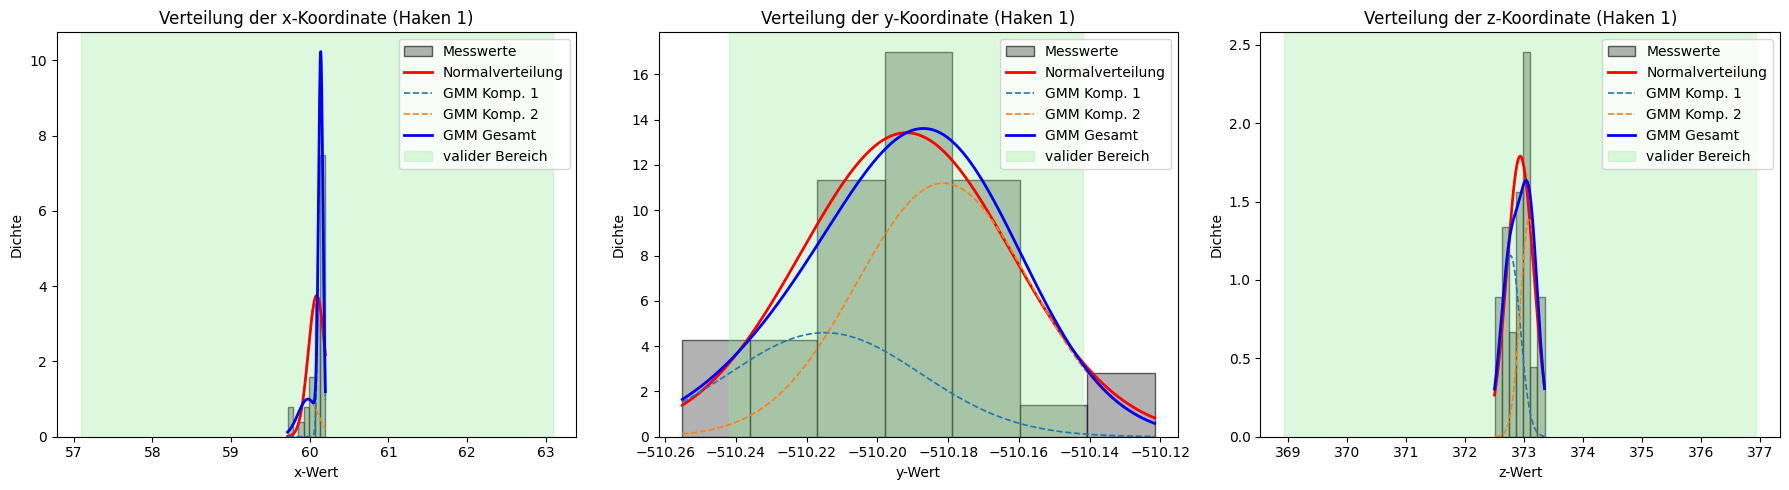

x-Achse: μ-Komponenten = [60.14 59.98], σ-Komponenten = [0.03 0.13], Gewichte = [0.68 0.32]
Zielbereich (angepasst): [57.09, 63.09] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-510.21 -510.18], σ-Komponenten = [0.03 0.02], Gewichte = [0.31 0.69]
Zielbereich (angepasst): [-510.24, -510.14] → Wahrscheinlichkeit = 90.74 %

z-Achse: μ-Komponenten = [372.77 373.08], σ-Komponenten = [0.17 0.15], Gewichte = [0.48 0.52]
Zielbereich (angepasst): [368.93, 376.93] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 90.74 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  2


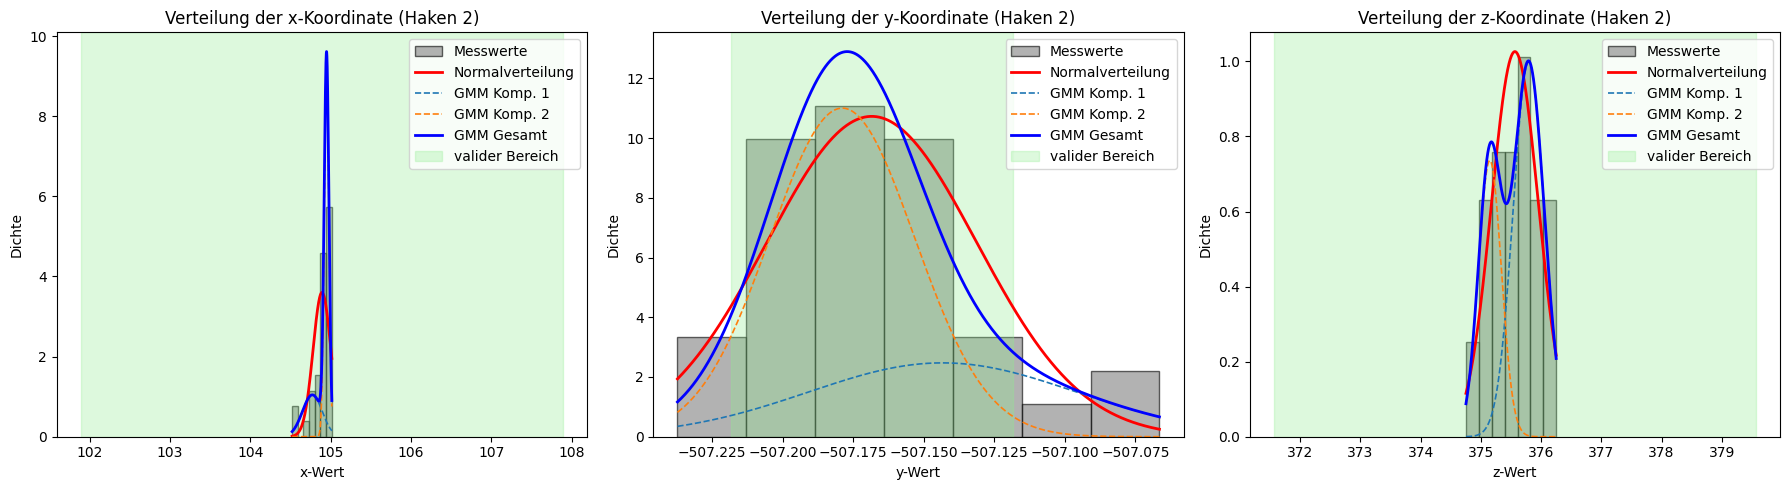

x-Achse: μ-Komponenten = [104.77 104.95], σ-Komponenten = [0.12 0.03], Gewichte = [0.32 0.68]
Zielbereich (angepasst): [101.89, 107.89] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-507.14 -507.18], σ-Komponenten = [0.05 0.03], Gewichte = [0.29 0.71]
Zielbereich (angepasst): [-507.22, -507.12] → Wahrscheinlichkeit = 84.58 %

z-Achse: μ-Komponenten = [375.79 375.15], σ-Komponenten = [0.26 0.19], Gewichte = [0.65 0.35]
Zielbereich (angepasst): [371.57, 379.57] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 84.58 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  3


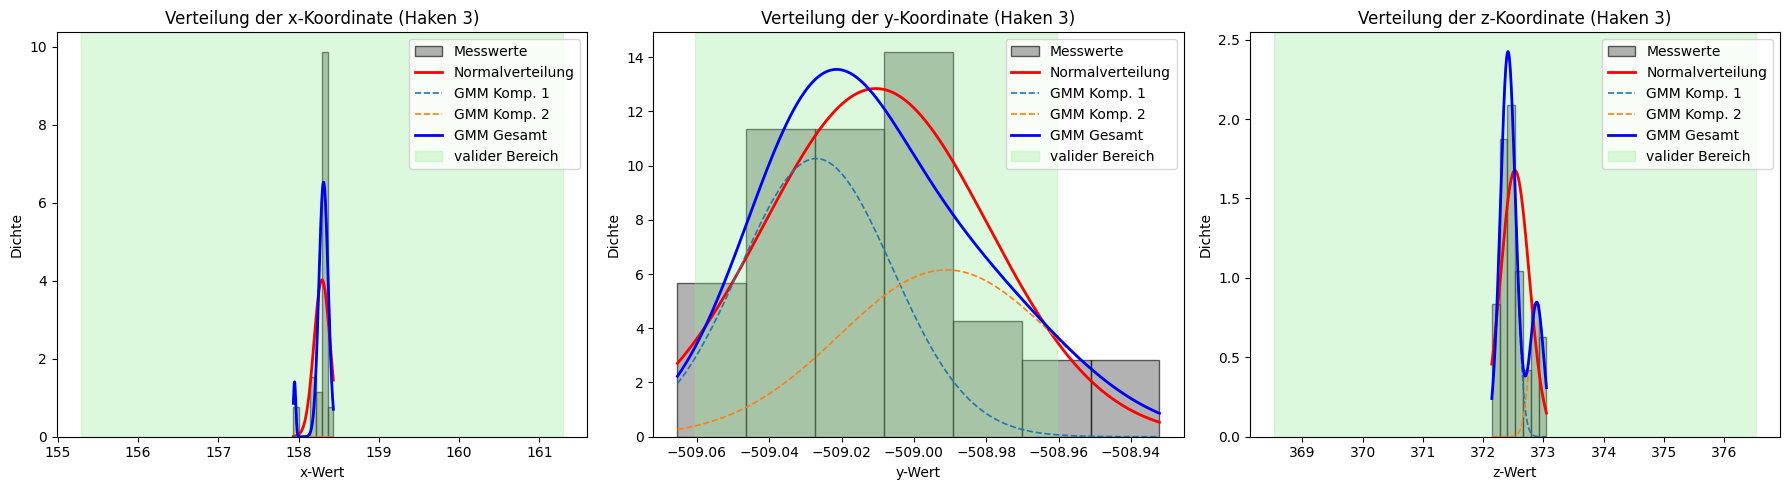

x-Achse: μ-Komponenten = [158.31 157.95], σ-Komponenten = [0.06 0.02], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [155.29, 161.29] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-509.03 -508.99], σ-Komponenten = [0.02 0.03], Gewichte = [0.54 0.46]
Zielbereich (angepasst): [-509.06, -508.96] → Wahrscheinlichkeit = 89.51 %

z-Achse: μ-Komponenten = [372.41 372.89], σ-Komponenten = [0.12 0.11], Gewichte = [0.76 0.24]
Zielbereich (angepasst): [368.53, 376.53] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 89.51 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  4


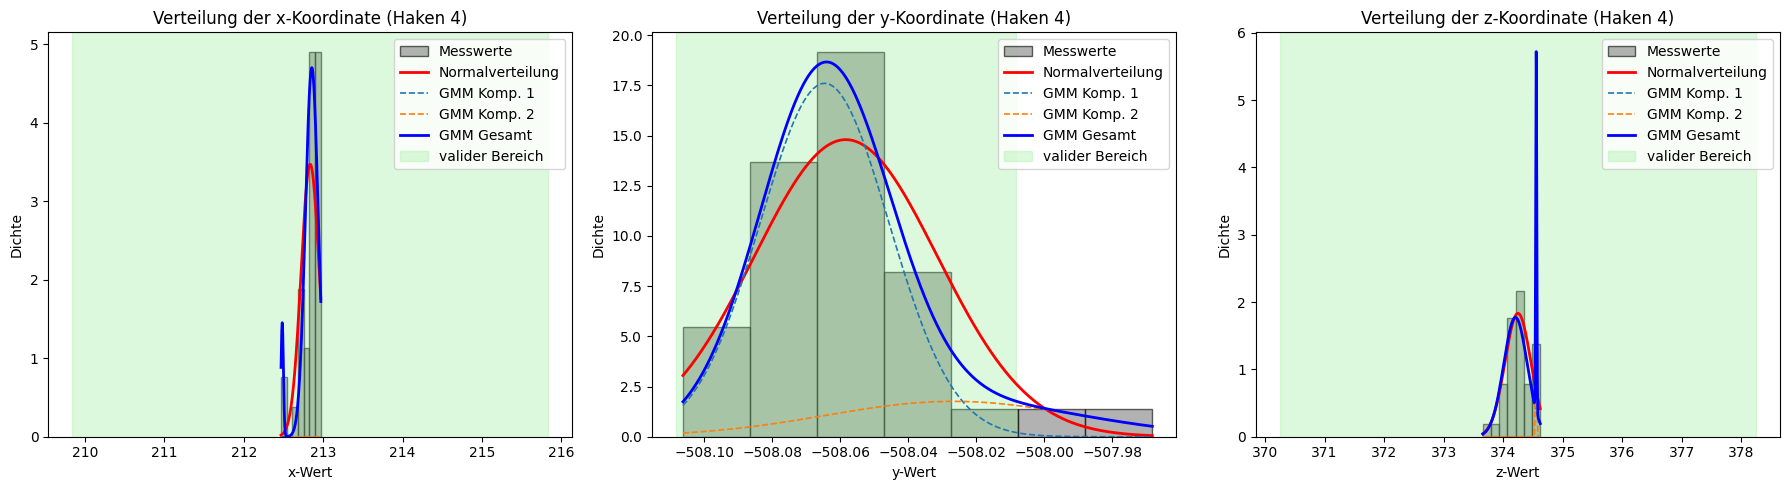

x-Achse: μ-Komponenten = [212.86 212.48], σ-Komponenten = [0.08 0.01], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [209.84, 215.84] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-508.06 -508.03], σ-Komponenten = [0.02 0.04], Gewichte = [0.83 0.17]
Zielbereich (angepasst): [-508.11, -508.01] → Wahrscheinlichkeit = 93.62 %

z-Achse: μ-Komponenten = [374.21 374.55], σ-Komponenten = [0.2  0.01], Gewichte = [0.88 0.12]
Zielbereich (angepasst): [370.25, 378.25] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 93.62 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  5


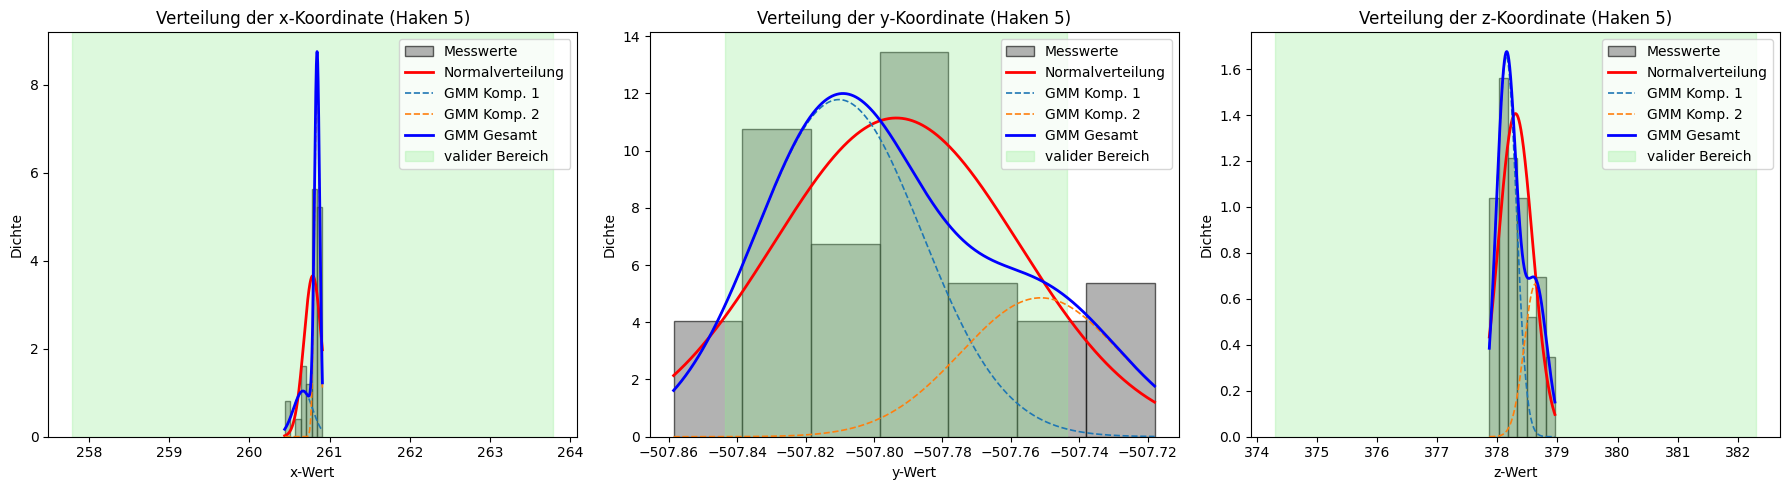

x-Achse: μ-Komponenten = [260.67 260.84], σ-Komponenten = [0.12 0.03], Gewichte = [0.31 0.69]
Zielbereich (angepasst): [257.79, 263.79] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-507.81 -507.75], σ-Komponenten = [0.02 0.02], Gewichte = [0.72 0.28]
Zielbereich (angepasst): [-507.84, -507.74] → Wahrscheinlichkeit = 83.17 %

z-Achse: μ-Komponenten = [378.15 378.64], σ-Komponenten = [0.17 0.19], Gewichte = [0.69 0.31]
Zielbereich (angepasst): [374.30, 382.30] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 83.17 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  6


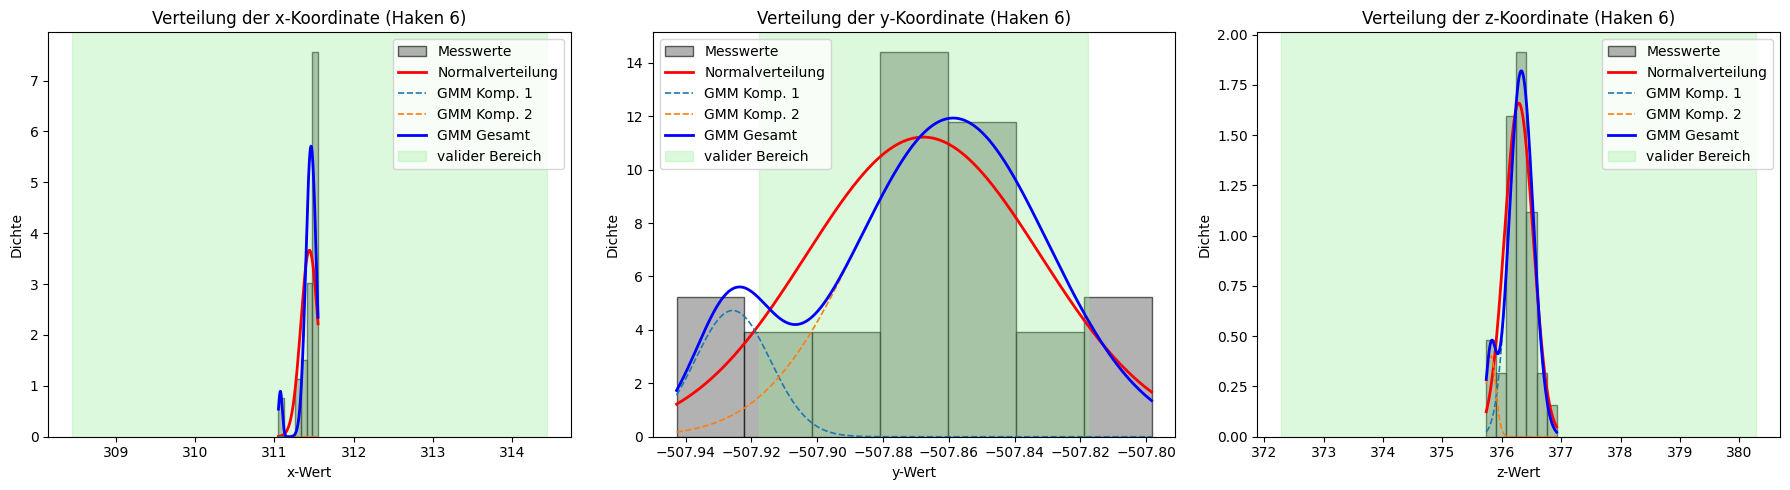

x-Achse: μ-Komponenten = [311.46 311.07], σ-Komponenten = [0.07 0.02], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [308.44, 314.44] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-507.93 -507.86], σ-Komponenten = [0.01 0.03], Gewichte = [0.14 0.86]
Zielbereich (angepasst): [-507.92, -507.82] → Wahrscheinlichkeit = 81.20 %

z-Achse: μ-Komponenten = [376.33 375.82], σ-Komponenten = [0.2  0.08], Gewichte = [0.92 0.08]
Zielbereich (angepasst): [372.29, 380.29] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 81.20 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  7


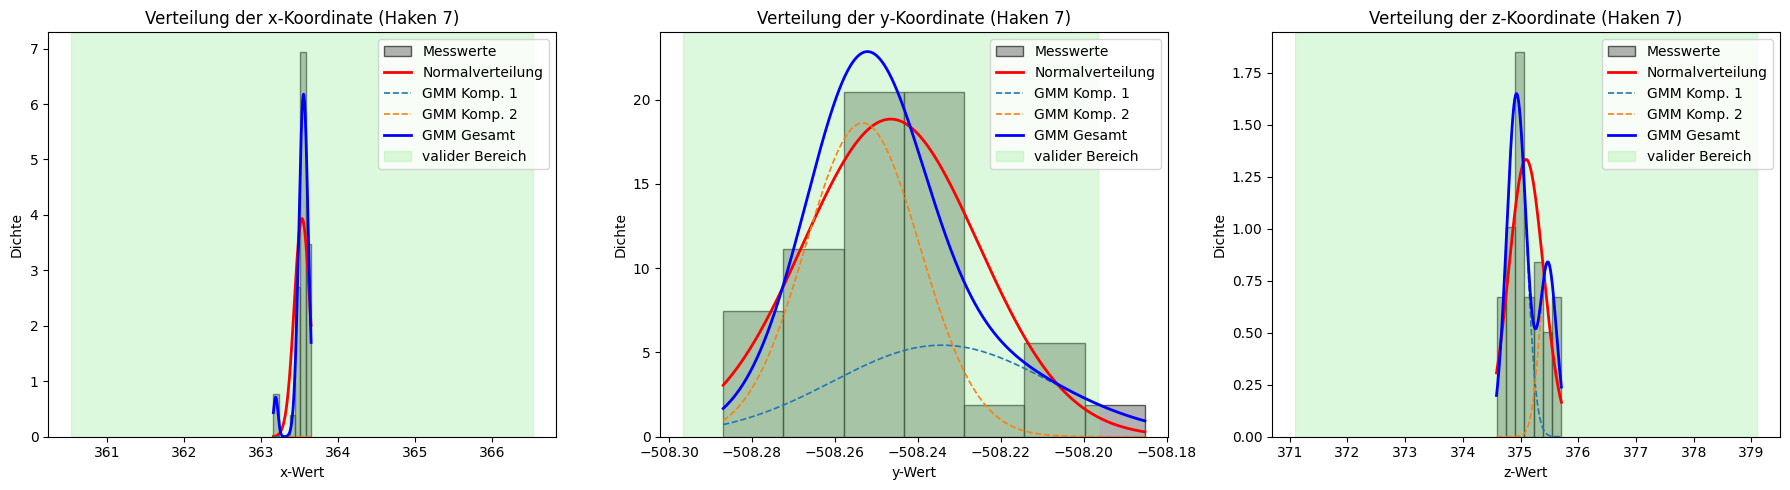

x-Achse: μ-Komponenten = [363.55 363.19], σ-Komponenten = [0.06 0.03], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [360.53, 366.53] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-508.23 -508.25], σ-Komponenten = [0.03 0.01], Gewichte = [0.36 0.64]
Zielbereich (angepasst): [-508.30, -508.20] → Wahrscheinlichkeit = 96.99 %

z-Achse: μ-Komponenten = [374.93 375.48], σ-Komponenten = [0.17 0.15], Gewichte = [0.69 0.31]
Zielbereich (angepasst): [371.10, 379.10] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 96.99 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  8


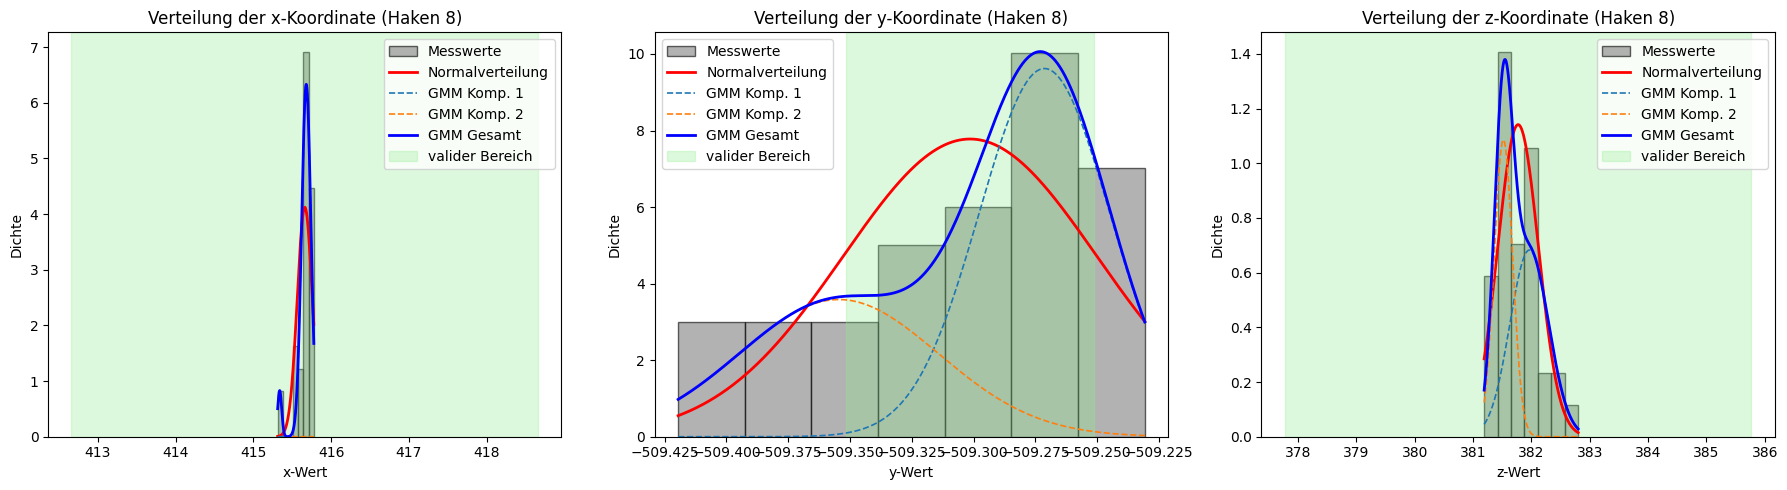

x-Achse: μ-Komponenten = [415.68 415.34], σ-Komponenten = [0.06 0.03], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [412.66, 418.66] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-509.27 -509.35], σ-Komponenten = [0.03 0.04], Gewichte = [0.64 0.36]
Zielbereich (angepasst): [-509.35, -509.25] → Wahrscheinlichkeit = 66.11 %

z-Achse: μ-Komponenten = [381.96 381.52], σ-Komponenten = [0.33 0.16], Gewichte = [0.57 0.43]
Zielbereich (angepasst): [377.77, 385.77] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 66.11 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  9


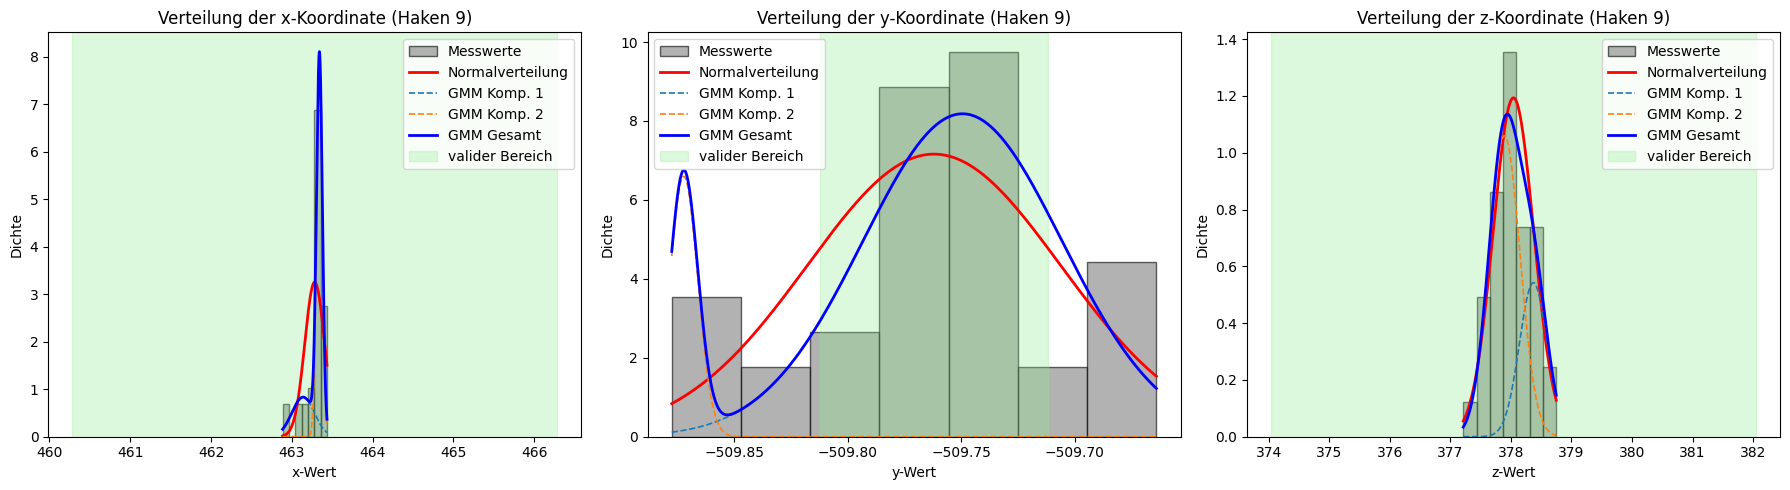

x-Achse: μ-Komponenten = [463.14 463.34], σ-Komponenten = [0.14 0.04], Gewichte = [0.29 0.71]
Zielbereich (angepasst): [460.28, 466.28] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-509.75 -509.87], σ-Komponenten = [0.04 0.01], Gewichte = [0.9 0.1]
Zielbereich (angepasst): [-509.81, -509.71] → Wahrscheinlichkeit = 65.30 %

z-Achse: μ-Komponenten = [378.37 377.89], σ-Komponenten = [0.23 0.26], Gewichte = [0.31 0.69]
Zielbereich (angepasst): [374.04, 382.04] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 65.30 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  10


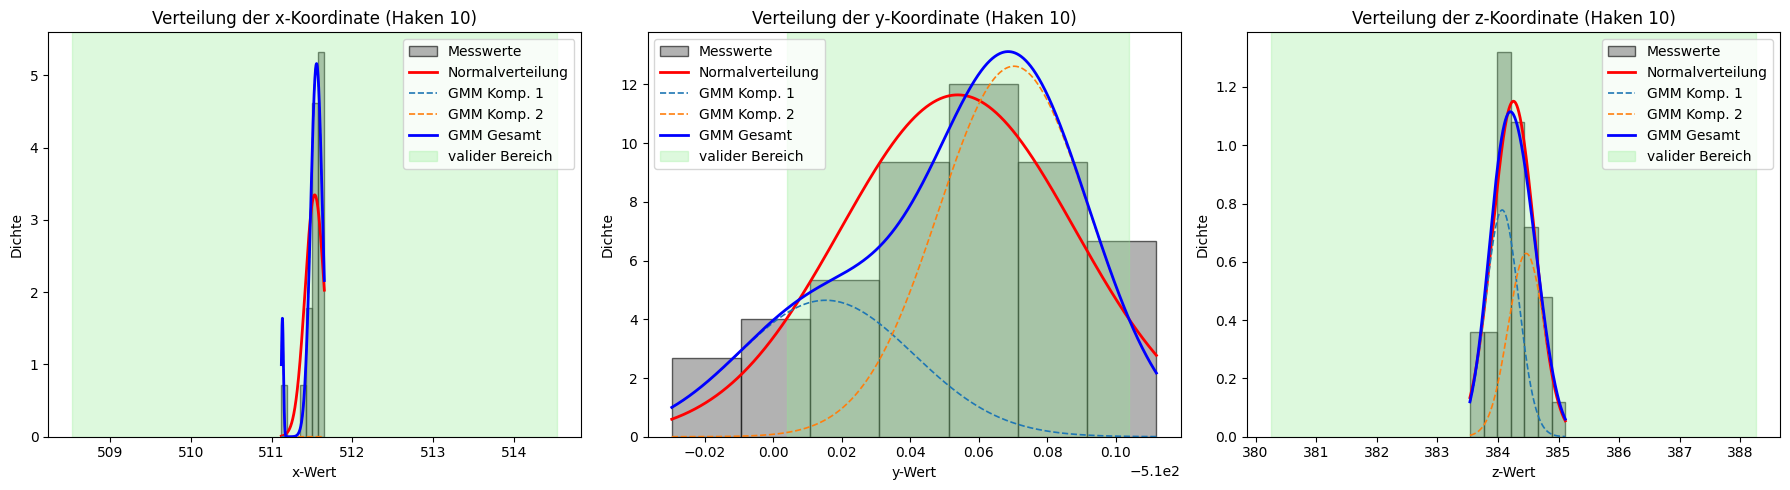

x-Achse: μ-Komponenten = [511.56 511.13], σ-Komponenten = [0.07 0.01], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [508.53, 514.53] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-509.98 -509.93], σ-Komponenten = [0.03 0.02], Gewichte = [0.3 0.7]
Zielbereich (angepasst): [-510.00, -509.90] → Wahrscheinlichkeit = 85.55 %

z-Achse: μ-Komponenten = [384.07 384.47], σ-Komponenten = [0.27 0.3 ], Gewichte = [0.53 0.47]
Zielbereich (angepasst): [380.26, 388.26] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 85.55 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  11


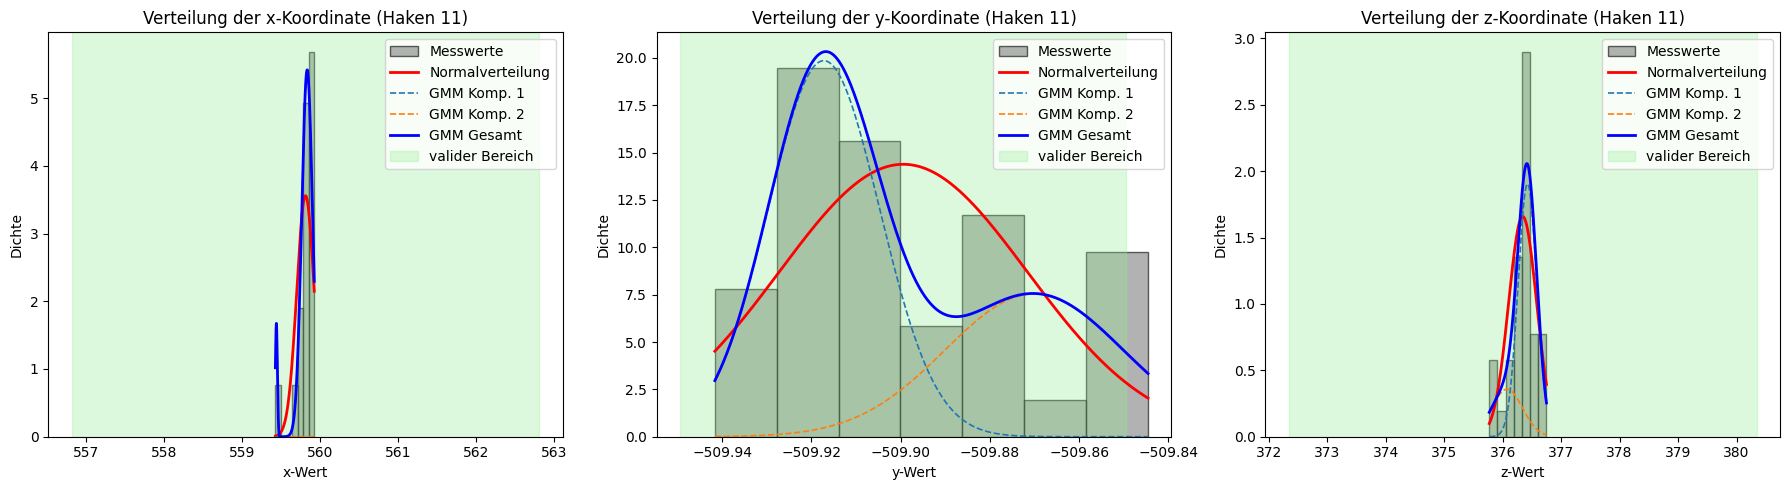

x-Achse: μ-Komponenten = [559.83 559.44], σ-Komponenten = [0.07 0.01], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [556.81, 562.81] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-509.92 -509.87], σ-Komponenten = [0.01 0.02], Gewichte = [0.62 0.38]
Zielbereich (angepasst): [-509.95, -509.85] → Wahrscheinlichkeit = 94.01 %

z-Achse: μ-Komponenten = [376.42 376.08], σ-Komponenten = [0.16 0.26], Gewichte = [0.76 0.24]
Zielbereich (angepasst): [372.34, 380.34] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 94.01 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  12


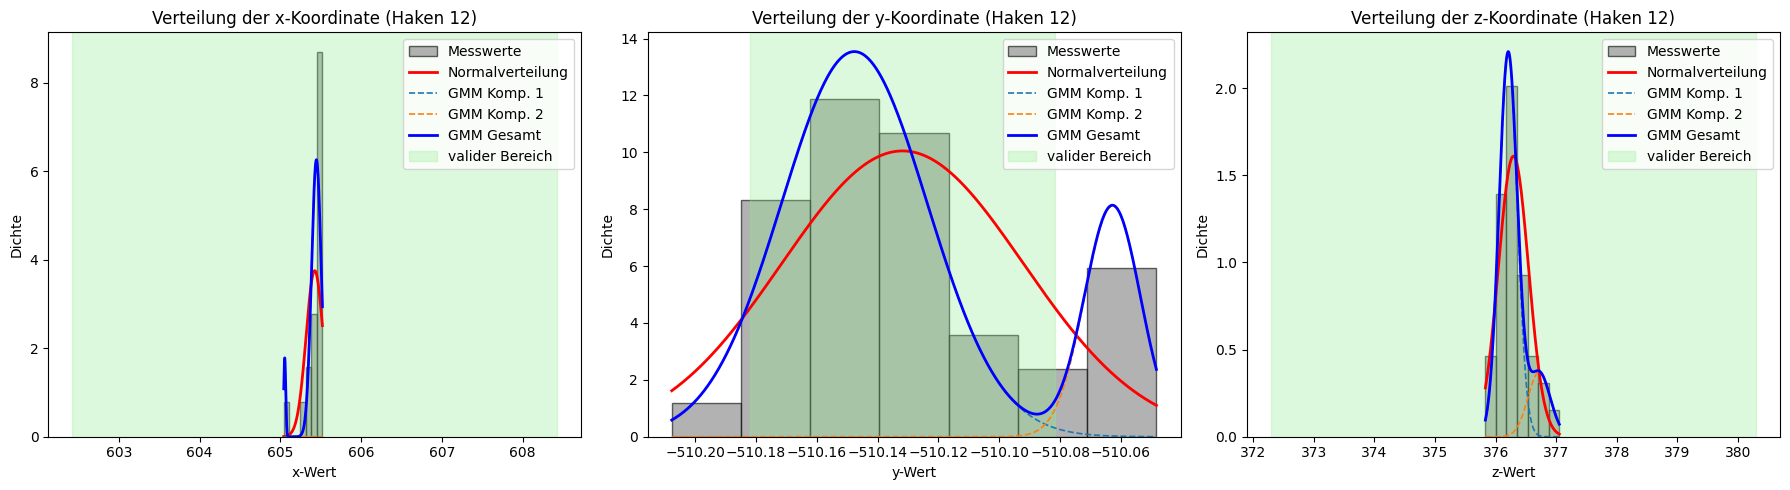

x-Achse: μ-Komponenten = [605.45 605.05], σ-Komponenten = [0.06 0.01], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [602.42, 608.42] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-510.15 -510.06], σ-Komponenten = [0.02 0.01], Gewichte = [0.81 0.19]
Zielbereich (angepasst): [-510.18, -510.08] → Wahrscheinlichkeit = 75.18 %

z-Achse: μ-Komponenten = [376.21 376.72], σ-Komponenten = [0.15 0.18], Gewichte = [0.83 0.17]
Zielbereich (angepasst): [372.29, 380.29] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 75.18 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  13


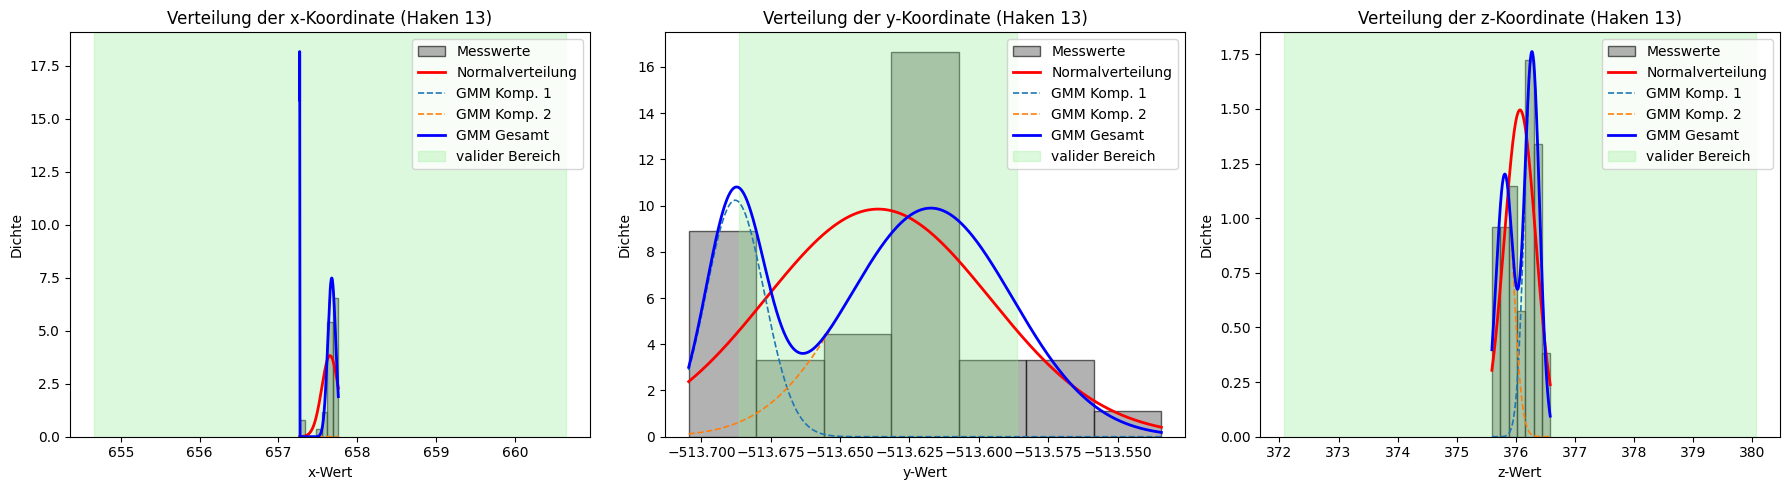

x-Achse: μ-Komponenten = [657.68 657.27], σ-Komponenten = [0.05 0.  ], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [654.65, 660.65] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-513.69 -513.62], σ-Komponenten = [0.01 0.03], Gewichte = [0.27 0.73]
Zielbereich (angepasst): [-513.69, -513.59] → Wahrscheinlichkeit = 73.61 %

z-Achse: μ-Komponenten = [376.28 375.81], σ-Komponenten = [0.13 0.15], Gewichte = [0.56 0.44]
Zielbereich (angepasst): [372.07, 380.07] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 73.61 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  14


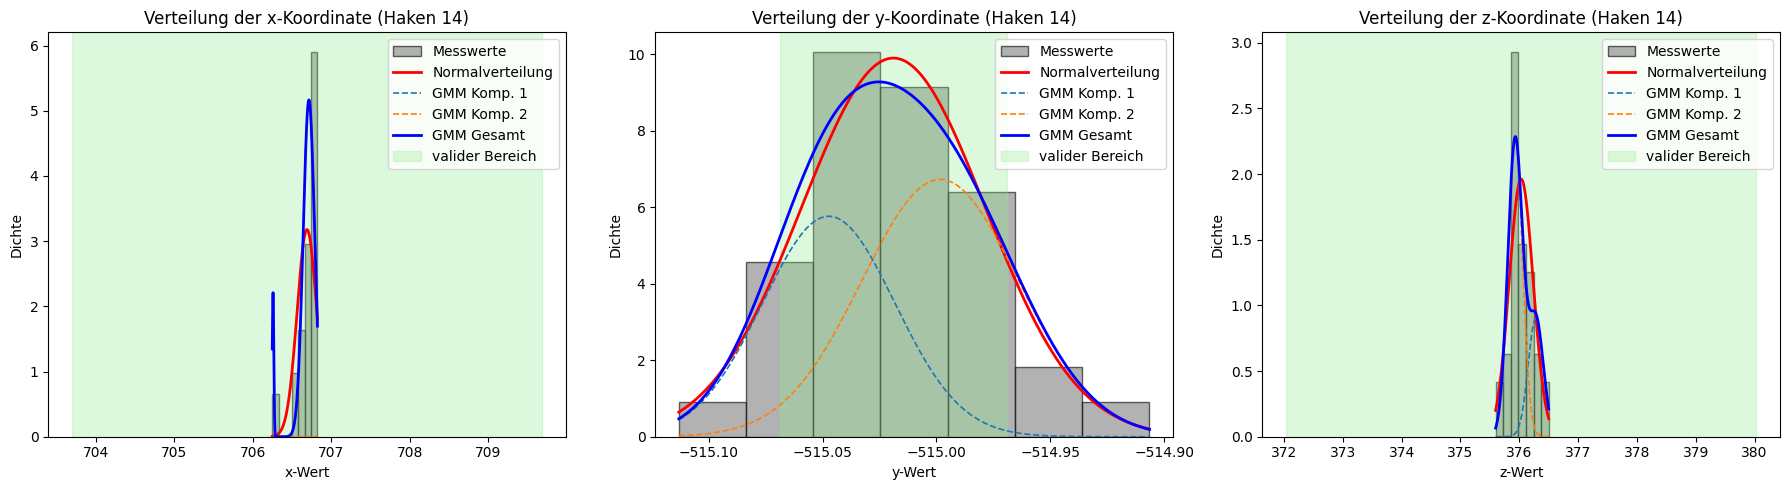

x-Achse: μ-Komponenten = [706.71 706.26], σ-Komponenten = [0.07 0.01], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [703.69, 709.69] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-515.05 -515.  ], σ-Komponenten = [0.03 0.03], Gewichte = [0.42 0.58]
Zielbereich (angepasst): [-515.07, -514.97] → Wahrscheinlichkeit = 77.73 %

z-Achse: μ-Komponenten = [376.28 375.93], σ-Komponenten = [0.13 0.12], Gewichte = [0.29 0.71]
Zielbereich (angepasst): [372.03, 380.03] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 77.73 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  15


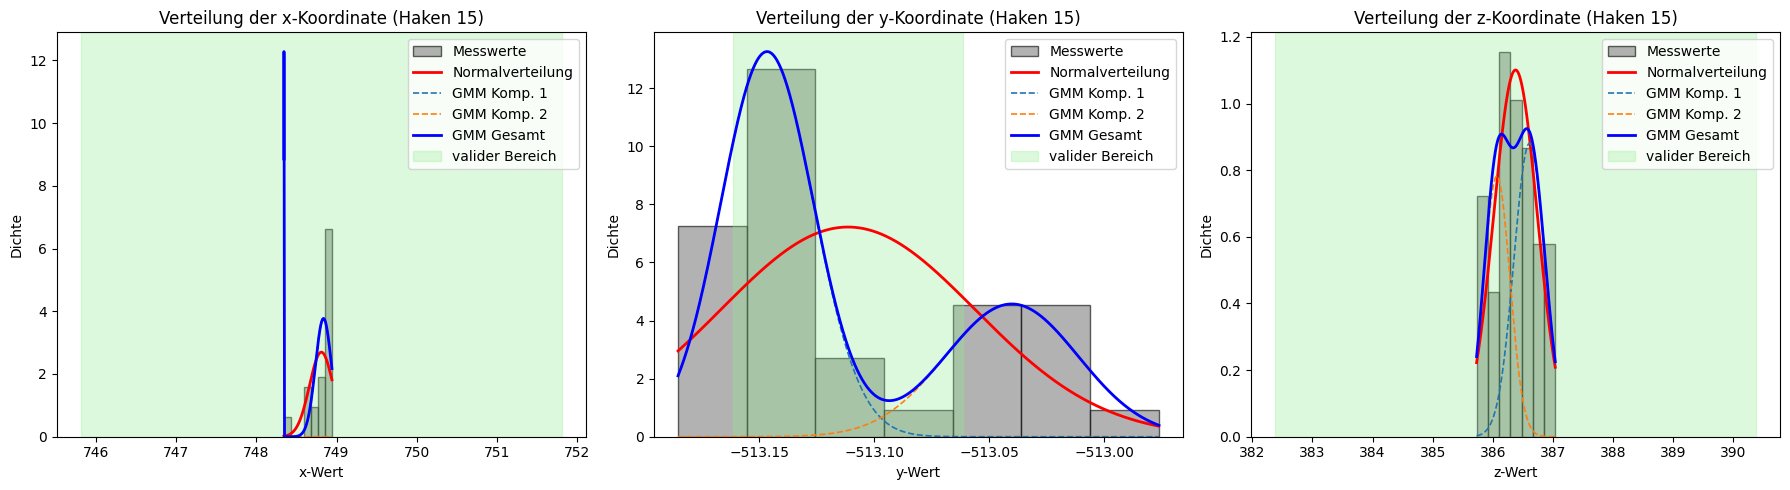

x-Achse: μ-Komponenten = [748.84 748.34], σ-Komponenten = [0.1 0. ], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [745.81, 751.81] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-513.15 -513.04], σ-Komponenten = [0.02 0.03], Gewichte = [0.67 0.33]
Zielbereich (angepasst): [-513.16, -513.06] → Wahrscheinlichkeit = 59.09 %

z-Achse: μ-Komponenten = [386.61 386.07], σ-Komponenten = [0.26 0.22], Gewichte = [0.57 0.43]
Zielbereich (angepasst): [382.38, 390.38] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 59.09 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  16


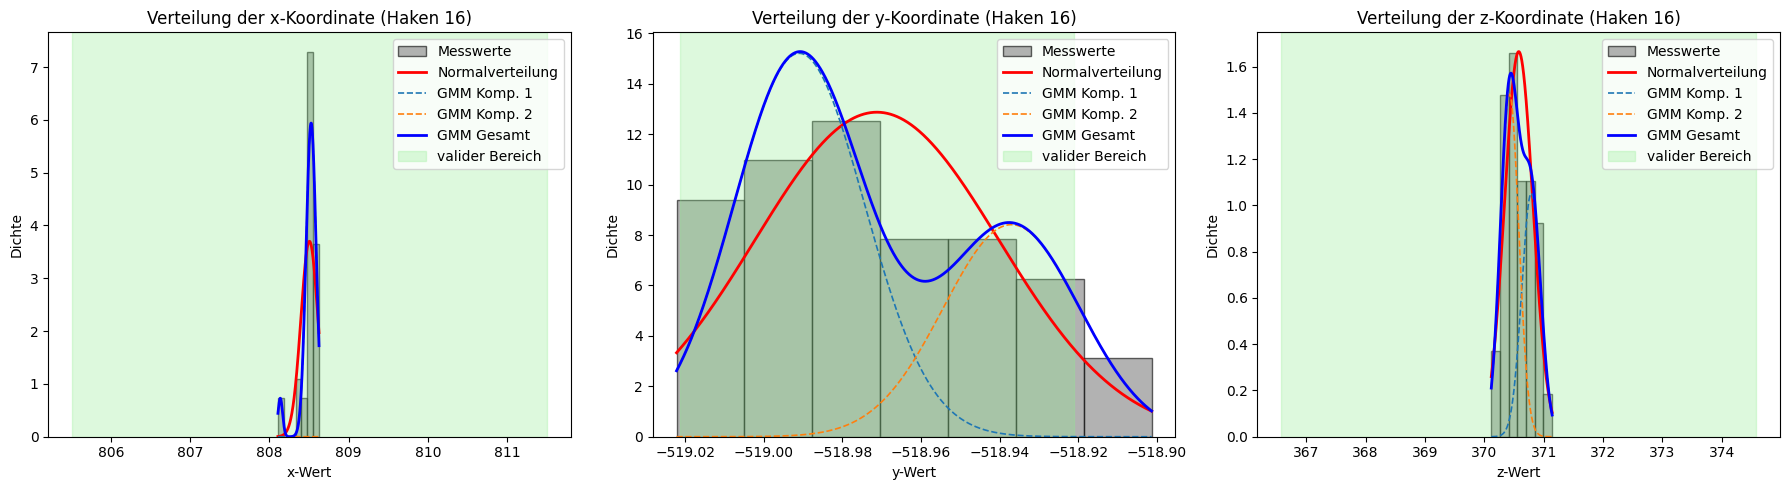

x-Achse: μ-Komponenten = [808.53 808.14], σ-Komponenten = [0.06 0.03], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [805.51, 811.51] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-518.99 -518.94], σ-Komponenten = [0.02 0.02], Gewichte = [0.63 0.37]
Zielbereich (angepasst): [-519.02, -518.92] → Wahrscheinlichkeit = 91.18 %

z-Achse: μ-Komponenten = [370.79 370.42], σ-Komponenten = [0.16 0.16], Gewichte = [0.42 0.58]
Zielbereich (angepasst): [366.58, 374.58] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 91.18 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  17


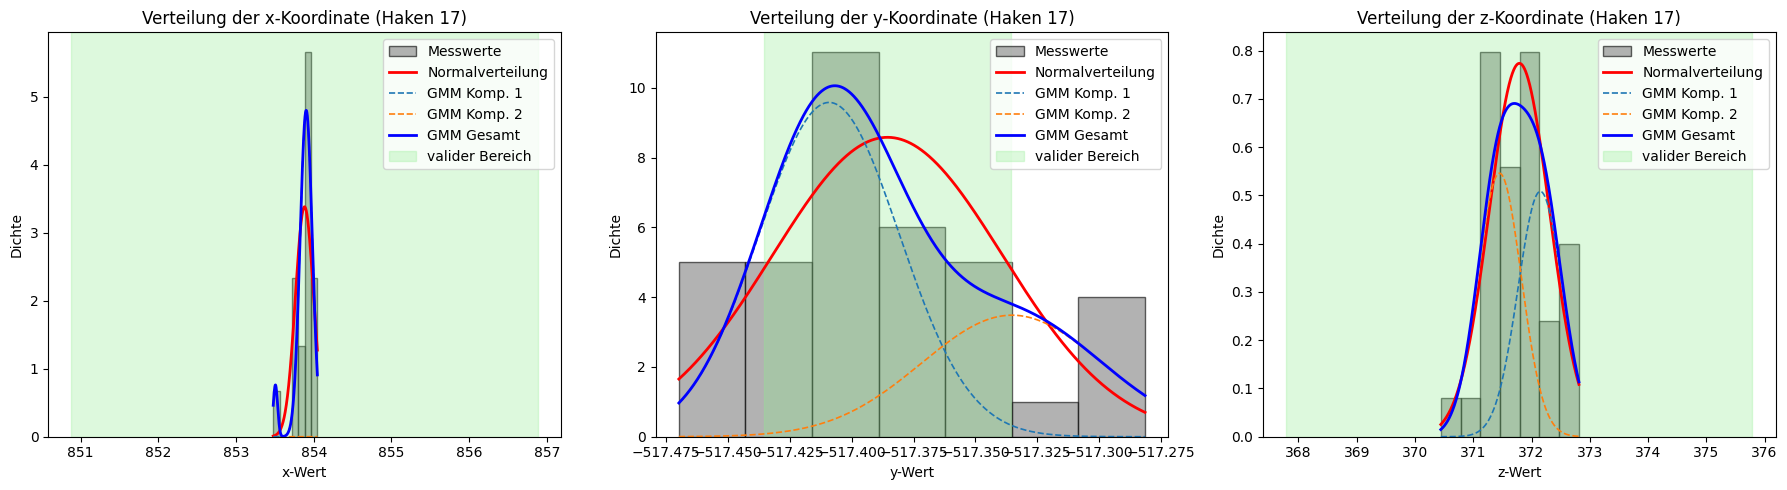

x-Achse: μ-Komponenten = [853.9  853.51], σ-Komponenten = [0.08 0.03], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [850.88, 856.88] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-517.41 -517.34], σ-Komponenten = [0.03 0.04], Gewichte = [0.68 0.32]
Zielbereich (angepasst): [-517.44, -517.34] → Wahrscheinlichkeit = 71.54 %

z-Achse: μ-Komponenten = [372.15 371.45], σ-Komponenten = [0.38 0.38], Gewichte = [0.49 0.51]
Zielbereich (angepasst): [367.79, 375.79] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 71.54 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  18


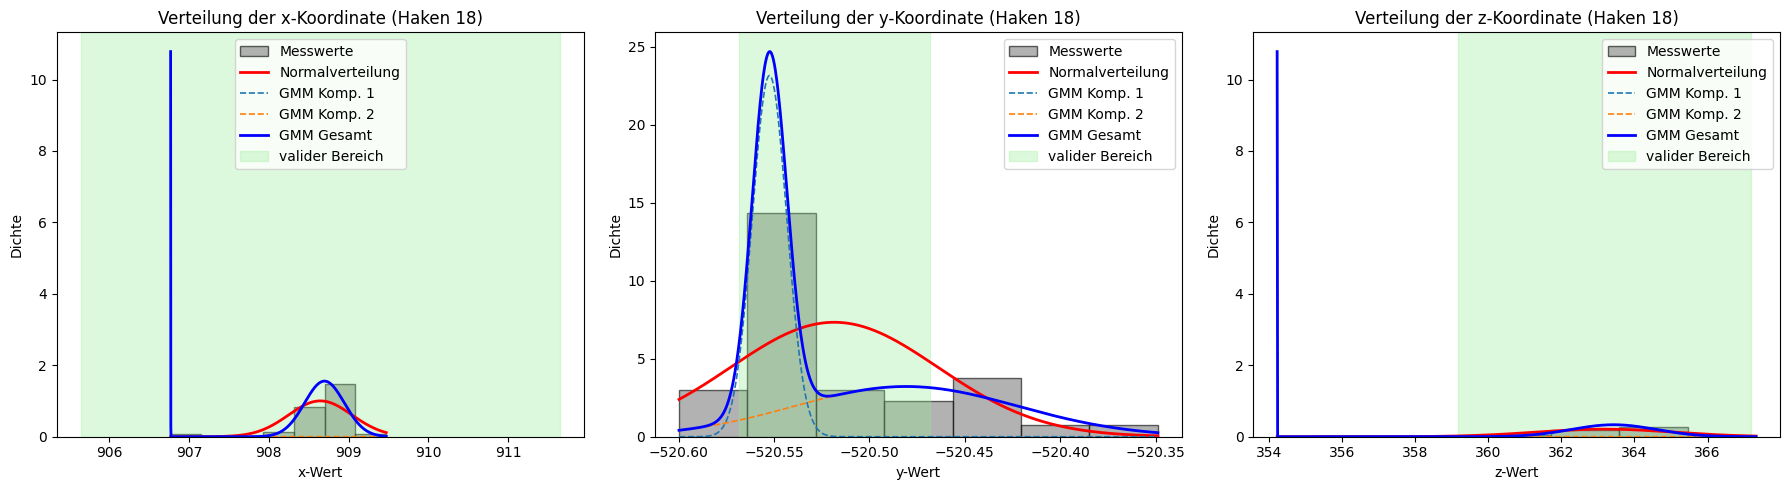

x-Achse: μ-Komponenten = [908.7  906.77], σ-Komponenten = [0.25 0.  ], Gewichte = [0.97 0.03]
Zielbereich (angepasst): [905.65, 911.65] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-520.55 -520.48], σ-Komponenten = [0.01 0.06], Gewichte = [0.53 0.47]
Zielbereich (angepasst): [-520.57, -520.47] → Wahrscheinlichkeit = 75.03 %

z-Achse: μ-Komponenten = [363.43 354.22], σ-Komponenten = [1.16 0.  ], Gewichte = [0.97 0.03]
Zielbereich (angepasst): [359.18, 367.18] → Wahrscheinlichkeit = 97.23 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 72.95 %



In [41]:
for hook_num in range(len(dicts_list[0])):
    plot_prob_an_hist(hook_num+1, True)

***
# **Triangulationsmethoden**

In [161]:
horizontal_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/1_Horizontale-Triangulation/d_nah/global_hook_dict_horizontal.csv'
vertical_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/1_Horizontale-Triangulation/d_weit/global_hook_dict_horizontal.csv'

In [162]:
horizontal_dict = load_csv_to_dict(filename=horizontal_filepath)
vertical_dict = load_csv_to_dict(filename=vertical_filepath)

In [163]:
print(len(horizontal_dict))
print(len(vertical_dict))

23
23


In [164]:
def get_plot_values(dict1):
    """
    Holt die Werte für XYZ aus Dict und liefert Listen mit den Werten zurück, die dan geplottet werden können
    """
    xyz_hook_in_workframe_list = []
    xyz_tip_in_workframe_list = []
    xyz_lowpoint_in_workframe_list = []

    for idx, key in enumerate(dict1):
        xyz_hook_in_workframe_list.append(dict1[key]['xyz_hook_in_workframe'])
        xyz_tip_in_workframe_list.append(dict1[key]['xyz_tip_in_workframe'])
        xyz_lowpoint_in_workframe_list.append(dict1[key]['xyz_lowpoint_in_workframe'])

    return xyz_hook_in_workframe_list, xyz_tip_in_workframe_list, xyz_lowpoint_in_workframe_list

In [165]:
def calc_axiswise_differences(list1, list2):
    """
    Berechnet die absoluten Distanzen zwischen zwei 3D-Punktlisten achsenweise.
    
    Rückgabe:
        - dx: Liste der |x1 - x2| Werte
        - dy: Liste der |y1 - y2| Werte
        - dz: Liste der |z1 - z2| Werte
    """
    arr1 = np.array(list1)
    arr2 = np.array(list2)
    
    diffs = arr1 - arr2  # shape: (n, 3)
    
    dx = diffs[:, 0].tolist()
    dy = diffs[:, 1].tolist()
    dz = diffs[:, 2].tolist()
    
    return dx, dy, dz

In [166]:
def calc_euclidean_distance(list1, list2):
    """
    Berechnet die euklidische Distanz der Punkte
    """
    arr1 = np.array(list1)
    arr2 = np.array(list2)
    diffs = np.linalg.norm(arr1 - arr2, axis=1)
    return diffs.tolist()

In [167]:
xyz_hook1_in_workframe, xyz_tip1_in_workframe, xyz_lowpoint1_in_workframe = get_plot_values(dict1 = horizontal_dict)
xyz_hook2_in_workframe, xyz_tip2_in_workframe, xyz_lowpoint2_in_workframe = get_plot_values(dict1 = vertical_dict)
tip_euclidean_diff = calc_euclidean_distance(xyz_tip1_in_workframe, xyz_tip2_in_workframe)
dx, dy, dz = calc_axiswise_differences(xyz_tip1_in_workframe, xyz_tip2_in_workframe)

In [ ]:
def plot_3d_point(points1, points2, diff, dx, dy, dz, plottitle='Gesamtvergleich der Triangulationsmethoden'):
    """
    Zeichnet 3D-Vergleich der Punkte und rechts daneben zwei 2D-Plots:
    - oben: Gesamtdistanz
    - unten: Achsenweise Differenz (dx, dy, dz)
    """
    # In x, y, z aufteilen
    x_vals_1 = [p[0] for p in points1]
    y_vals_1 = [-p[1] for p in points1]
    z_vals_1 = [p[2] for p in points1]

    x_vals_2 = [p[0] for p in points2]
    y_vals_2 = [-p[1] for p in points2]
    z_vals_2 = [p[2] for p in points2]

    indices = list(range(len(diff)))

    fig = plt.figure(figsize=(18, 8))
    # fig.suptitle("Gesamtvergleich der Triangulationsergebnisse", fontsize=16, fontweight='bold')
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])
    
    ##### 3D-Plot links (beide Zeilen der linken Spalte)
    ax3d = fig.add_subplot(gs[:, 0], projection='3d')
    ax3d.scatter(x_vals_1, z_vals_1, y_vals_1, color='blue', s=60, label='horizontal')
    ax3d.scatter(x_vals_2, z_vals_2, y_vals_2, color='red', s=60, label='vertical')
    # Punkte beschriften mit Index
    for i, (x1, y1, z1) in enumerate(zip(x_vals_1, y_vals_1, z_vals_1)):
        ax3d.text(x1, z1, y1, f'{i+1}', color='black', fontsize=8)

    for i, (x2, y2, z2) in enumerate(zip(x_vals_2, y_vals_2, z_vals_2)):
        ax3d.text(x2, z2, y2, f'{i+1}', color='black', fontsize=8)
    ax3d.set_xlabel("X")
    ax3d.set_ylabel("Z")
    ax3d.set_zlabel("Y")
    ax3d.set_title("Vergleich Triangulationsverfahren Hakenspitze")
    ax3d.set_xlim([0, 1000])
    ax3d.set_ylim([200, 380])
    ax3d.set_zlim([0, 600])
    ax3d.legend()

    ##### 2D-Plot oben rechts (Gesamtdistanz)
    ax2d_1 = fig.add_subplot(gs[0, 1])
    ax2d_1.plot(indices, diff, label='euclidean distance', marker='o', color='green')
    ax2d_1.set_xlabel("Instanz")
    ax2d_1.set_ylabel("Distanz (Einheit)")
    ax2d_1.set_title("Euklidsche Distanz")
    ax2d_1.grid(True)
    ax2d_1.legend()

    ##### 2D-Plot unten rechts (dx, dy, dz)
    ax2d_2 = fig.add_subplot(gs[1, 1])
    ax2d_2.plot(indices, dx, label='dx', marker='o')
    ax2d_2.plot(indices, dy, label='dy', marker='s')
    ax2d_2.plot(indices, dz, label='dz', marker='^')
    ax2d_2.set_xlabel("Instanz")
    ax2d_2.set_ylabel("Abweichung")
    ax2d_2.set_title("Achsenweise Abweichung (horizontal - vertikal)")
    ax2d_2.grid(True)
    ax2d_2.legend()

    fig.suptitle(plottitle, fontsize=16, fontweight='bold', x=0.6)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

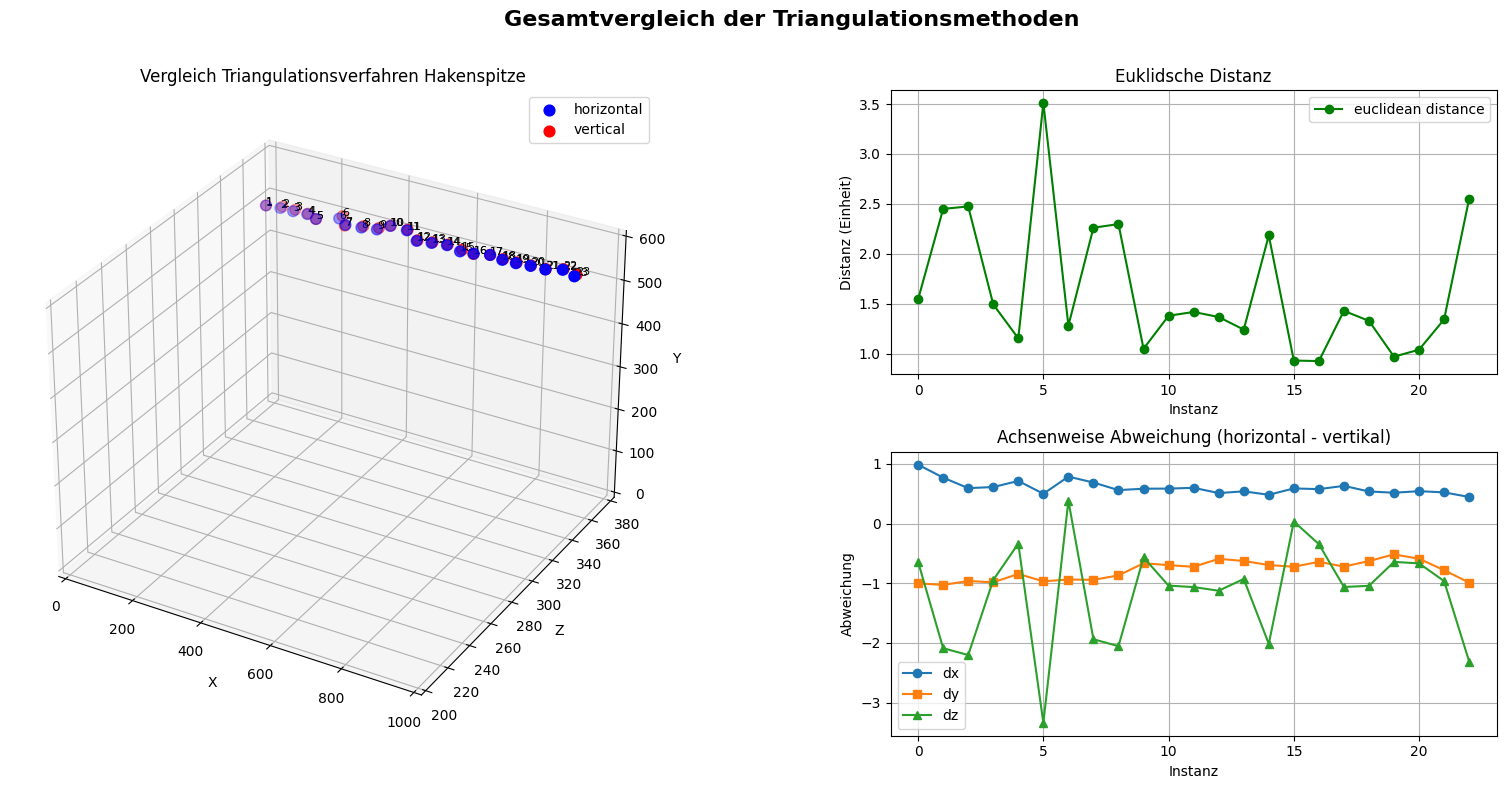

In [169]:
plot_3d_point(xyz_tip1_in_workframe, xyz_tip2_in_workframe, tip_euclidean_diff, dx, dy, dz)

In [170]:
def get_mean_of_axis_coords(list):
    """
    Berechnet den Mittelwert einer Koordinate über alle Instanzen hinweg"
    """
    x_vals = [p[0] for p in list]
    y_vals = [-p[1] for p in list]
    z_vals = [p[2] for p in list]

    x_mean = np.mean(x_vals)
    y_mean = np.mean(y_vals)
    z_mean = np.mean(z_vals)

    return x_mean, y_mean, z_mean

In [171]:
_, _, z_horizontal = get_mean_of_axis_coords(xyz_tip1_in_workframe)
_, _, z_vertical = get_mean_of_axis_coords(xyz_tip2_in_workframe)

In [172]:
print(z_horizontal)
print(z_vertical)

359.93575066002484
361.10472694674127
